# SoundDiffSep推論テスト（OverlapAdd版）

このノートブックは、音声分離モデル（SoundDiffSep）を使用してシミュレートされた音響環境での推論テストを行います。

## 概要
- **音響シミュレーション**: PyRoomAcousticsを使用した室内音響シミュレーション
- **音声分離**: 深層学習モデル（ResUNet）による音声分離
- **OverlapAdd処理**: 長い音声を効率的に処理するためのセグメント化処理
- **性能評価**: SDR（Signal-to-Distortion Ratio）による分離性能の評価

## 1. ライブラリのインポート

In [1]:
#%matplotlib widget
import numpy as np
import pyroomacoustics as pra
import librosa
import os
import matplotlib.pyplot as plt
from wandas import ChannelFrame
from torchmetrics.audio.sdr import (
    signal_distortion_ratio as sdr,
)
import torch
from sounddiffsep.model_loader import easy_load_model, separate_audio
from sounddiffsep.models.overlap_add import OverlapAdd

## 2. 音響シミュレーション環境の設定

PyRoomAcousticsを使用して、室内音響環境をシミュレートします。以下の要素を含みます：

- **音声データ**: target.flac（分離対象）、noise1.flac、noise2.flac（干渉音）
- **部屋の設定**: 8m×8mの正方形の部屋
- **音響パラメータ**: 吸収率0.4、散乱率0.1、最大反射回数12回
- **マイク配置**: 2つのマイクロフォンを異なる位置に配置
- **音源配置**: 3つの音源を異なる位置に配置

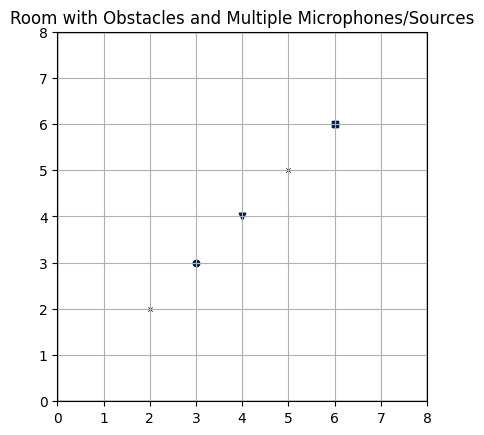

In [2]:
data_dir = "../data"
fs = 32000
duration = 10
source_audio_files = [
    "target.flac", 
    "noise1.flac", 
    "noise2.flac"
]
source_audio_files = [os.path.join(data_dir, f) for f in source_audio_files]
assert all(os.path.exists(f) for f in source_audio_files), "音声ファイルが見つかりません"

source_signals = np.array([librosa.load(file, sr=fs, duration=duration, mono=True)[0] for file in source_audio_files])
source_signals /= source_signals.std(-1, keepdims=True)
source_signals /= source_signals.max()

# 部屋の形状を設定（角の座標）
corners = np.array([
    [0, 0], [8, 0], [8, 8], [0, 8]
]).T  # 転置して [2, N] の形に

# 壁の吸収率を設定
absorption = 0.4  # 吸収率
scattering = 0.1  # 散乱率

# 部屋の作成
room = pra.Room.from_corners(
    corners=corners,
    fs=fs,
    materials=pra.Material(absorption, scattering),
    max_order=12  # 反射の最大回数
)
# マイクを配置
mic_positions = np.array([[2.0, 2.0], [5.0, 5.0]]).T  # 2つのマイクの座標
room.add_microphone_array(mic_positions)

# 音源を配置
# 音源配置と信号追加
source_positions = [[3.0, 3.0], [6.0, 6.0], [4.0, 4.0]]  # 3つの音源の座標
for position, signal in zip(source_positions, source_signals):
    room.add_source(position, signal=signal)

# 描画
fig, ax = room.plot()
ax.set_title("Room with Obstacles and Multiple Microphones/Sources")
ax.grid()
plt.show()

## 3. 音響シミュレーションの実行

室内音響シミュレーションを実行し、マイクで収録された混合信号と、分離対象となるクリーン信号を取得します。

- **room.simulate()**: 音響シミュレーションを実行
- **mix_signals**: マイクで収録された混合信号（反響込み）
- **clean_signals**: 分離対象のクリーン信号（第1音源のみ）
- **ChannelFrame**: 後の分析のためのデータ構造に変換

In [3]:
# シミュレーション実行
room.simulate()
mix_signals = room.mic_array.signals
clean_signals = room.simulate(return_premix=True)

val_signal = ChannelFrame.from_ndarray(
    np.vstack((mix_signals, clean_signals[0,0,None])), 
    sampling_rate=fs, 
    labels=["mixed_mic1", "mixed_mic2"]+["clean_mic1"])

from_ndarray is deprecated. Use from_numpy instead.


## 4. 音声分離モデルの読み込み

SoundDiffSepライブラリを使用して、事前訓練済みのResUNetモデルを読み込みます。

- **easy_load_model**: 簡単にモデルを読み込むためのヘルパー関数
- **device**: GPU（CUDA）または CPU での実行を指定

In [4]:
device = "cuda"  # "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")    
model = easy_load_model("resunet", device=device)

Using device: cuda
チェックポイントの最初の数個のキー: ['ss_model.base.stft.conv_real.weight', 'ss_model.base.stft.conv_imag.weight', 'ss_model.base.istft.ola_window']
調整後のキー数: 256
チェックポイントの最初の数個のキー: ['ss_model.base.stft.conv_real.weight', 'ss_model.base.stft.conv_imag.weight', 'ss_model.base.istft.ola_window']
調整後のキー数: 256


## 5. 基本的な音声分離テスト

まず、ライブラリの標準的な`separate_audio`関数を使用して音声分離を実行し、ベースラインとなる性能を確認します。

- **separate_audio**: SoundDiffSepの標準分離関数
- **SDR計算**: 分離前後のSignal-to-Distortion Ratioを計算
- **SDRi**: SDR改善量（分離後SDR - 分離前SDR）

In [5]:
# 全モデルで分離を実行, 実行時間と分離性能を表示
mixed, noise = val_signal["mixed_mic1"].data, val_signal["mixed_mic2"].data
tgt = val_signal["clean_mic1"].data

# 結果を格納するためのDataFrame作成
result = separate_audio(model=model, mixed_signal=mixed, noise_signal=noise, device=device)

# 結果の処理　sdri sdrを計算
obs_sdr = sdr(torch.from_numpy(mixed), torch.from_numpy(tgt))
est_sdr = sdr(torch.from_numpy(result["estimated_target"][0]), torch.from_numpy(tgt))
sdri = est_sdr - obs_sdr

print(f"SDRi: {sdri.item():.2f} dB, SDR: {est_sdr.item():.2f} dB")

SDRi: 7.38 dB, SDR: 7.05 dB


## 6. OverlapAdd処理による効率的な音声分離

長い音声を効率的に処理するため、OverlapAdd手法を使用した専用の処理関数を定義します。

### `process_two_channel_audio`関数の特徴：
- **セグメント分割**: 長い音声を重複するセグメントに分割
- **ミニバッチ処理**: メモリ効率を考慮したバッチサイズでの処理
- **マルチチャンネル対応**: 混合信号とノイズ信号の2チャンネル同時処理
- **境界効果軽減**: Hann窓による平滑化処理

### 処理フロー：
1. 2チャンネル音声をセグメントに分割
2. 各セグメントをバッチ単位でDNNに入力
3. 推定ターゲット信号とノイズ信号を計算
4. OverlapAdd手法でセグメントを再結合

In [6]:
def process_two_channel_audio(mixed, noise_clean, model, ola=None, batch_size=32):
    """
    2チャンネルオーディオをミニバッチで処理する関数
    
    Args:
        mixed: 1チャンネル、混合信号
        noise_clean: 1チャンネル、ノイズ信号
        model: 処理するDNNモデル
        ola: OverlapAddインスタンス (Noneの場合は作成)
        batch_size: ミニバッチサイズ、メモリ使用量を調整するために使用
        
    Returns:
        処理された信号、形状は(2, length)
    """
    # 入力形状: [ch, length] = [2, length]
    x = np.stack([mixed, noise_clean], axis=0)
    
    # OverlapAddインスタンスの作成
    if ola is None:
        window_size = 1024
        hop_size = window_size // 2
        ola = OverlapAdd(window_size=window_size, hop_size=hop_size, window='hann')
    
    def batch_process_with_dnn(segments_batch):
        """
        バッチとしてマルチチャネルセグメントをDNNで処理
        
        Args:
            segments_batch: NumPy配列、形状(batch_size, n_channels, window_size)
            
        Returns:
            処理済み配列、形状(batch_size, n_channels, window_size)
        """
        if model is None:
            return segments_batch
        
        with torch.no_grad():
            # NumPy -> PyTorch、データ型を合わせる
            device = next(model.parameters()).device
            dtype = next(model.parameters()).dtype
            
            # 入力データをモデルと同じデータ型に変換
            tsegs = torch.from_numpy(segments_batch).to(device=device, dtype=dtype)
            
            # モデル処理
            est_targets = model(tsegs).squeeze()
            
            # 1セグメントだけの場合、次元が潰れるのを防ぐ
            if segments_batch.shape[0] == 1:
                est_targets = est_targets.unsqueeze(0)
                
            # 出力変換: ターゲット信号とノイズ信号
            if est_targets.dim() == 2:  # (batch_size, window_size)
                est_noise = (tsegs[:,0] - est_targets)
                result = torch.stack([est_targets, est_noise], dim=1)
            else:  # (batch_size, 1, window_size)
                est_noise = (tsegs[:,0:1] - est_targets)
                result = torch.cat([est_targets, est_noise], dim=1)
                
            # PyTorch -> NumPy
            return result.cpu().numpy()
    
    # OverlapAddによるミニバッチ処理
    processed = ola.process_signal(x, batch_process_with_dnn, batch_size=batch_size)
    
    # 出力形状: [ch, length] = [2, length]
    return processed


## 7. OverlapAdd手法による音声分離の実行

先ほど定義した`process_two_channel_audio`関数を使用して、実際に音声分離を実行します。

### パラメータ設定：
- **window_size**: 2秒分のサンプル数（fs*2 = 64,000サンプル）
- **hop_size**: ウィンドウサイズの半分（50%オーバーラップ）
- **batch_size**: 3（メモリ使用量を抑制）
- **window**: Hann窓（境界効果を軽減）

### 性能比較：
標準の`separate_audio`関数との性能比較を行い、OverlapAdd手法の効果を確認します。

In [7]:
mixed, noise = val_signal["mixed_mic1"].data, val_signal["mixed_mic2"].data
tgt = val_signal["clean_mic1"].data

window_size = fs*2
hop_size = window_size//2
ola = OverlapAdd(window_size=window_size, hop_size=hop_size, window='hann')

processed=process_two_channel_audio(mixed, noise, model, ola, batch_size=3)

# 結果の処理　sdri sdrを計算
obs_sdr = sdr(torch.from_numpy(mixed), torch.from_numpy(tgt))
est_sdr = sdr(torch.from_numpy(processed[0]), torch.from_numpy(tgt))
sdri = est_sdr - obs_sdr

print(f"SDRi: {sdri.item():.2f} dB, SDR: {est_sdr.item():.2f} dB")

sep_signal_segment = ChannelFrame.from_numpy(np.stack([mixed, noise, tgt, processed[0], processed[1]], axis=0), sampling_rate=fs, ch_labels=["mixed_mic1", "mixed_mic2", "tgt", "est_tgt", "est_noise"])


SDRi: 7.17 dB, SDR: 6.84 dB


/workspaces/SoundDiffSep/sounddiffsep/models/overlap_add.py:114: RuntimeWarning: invalid value encountered in divide
  output = np.where(mask, output / window_sum, output)


## 8. 結果の可視化と分析

ChannelFrameの`describe`メソッドを使用して、各信号のスペクトログラムを可視化し、分離結果を視覚的に評価します。

### 表示される信号：
- **mixed_mic1**: マイク1で収録された混合信号
- **mixed_mic2**: マイク2で収録された混合信号
- **tgt**: 分離対象のクリーン信号（正解）
- **est_tgt**: 推定されたターゲット信号
- **est_noise**: 推定されたノイズ信号

### パラメータ：
- **vmax=-20**: スペクトログラムの最大表示レベル（dB）
- **vmin=-80**: スペクトログラムの最小表示レベル（dB）

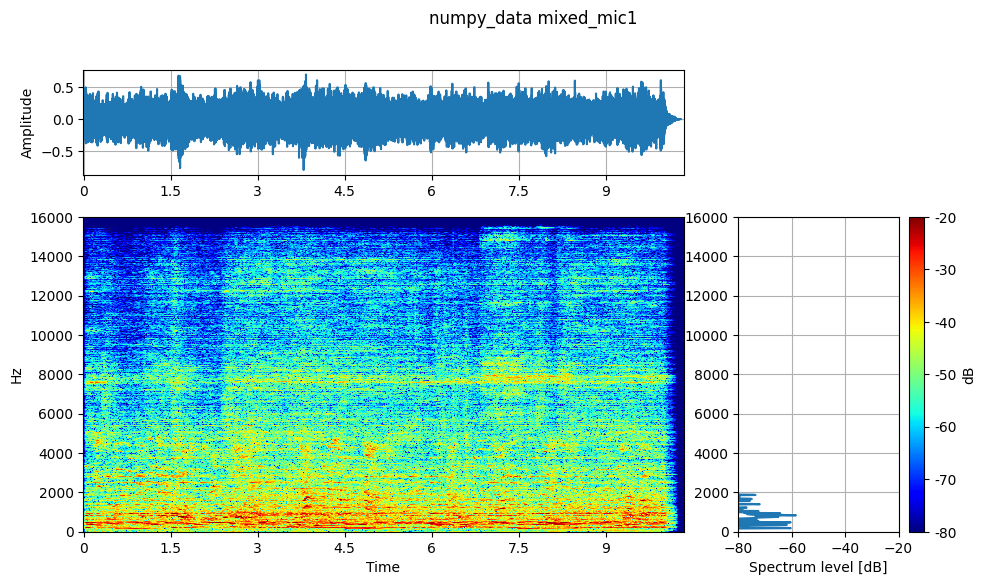

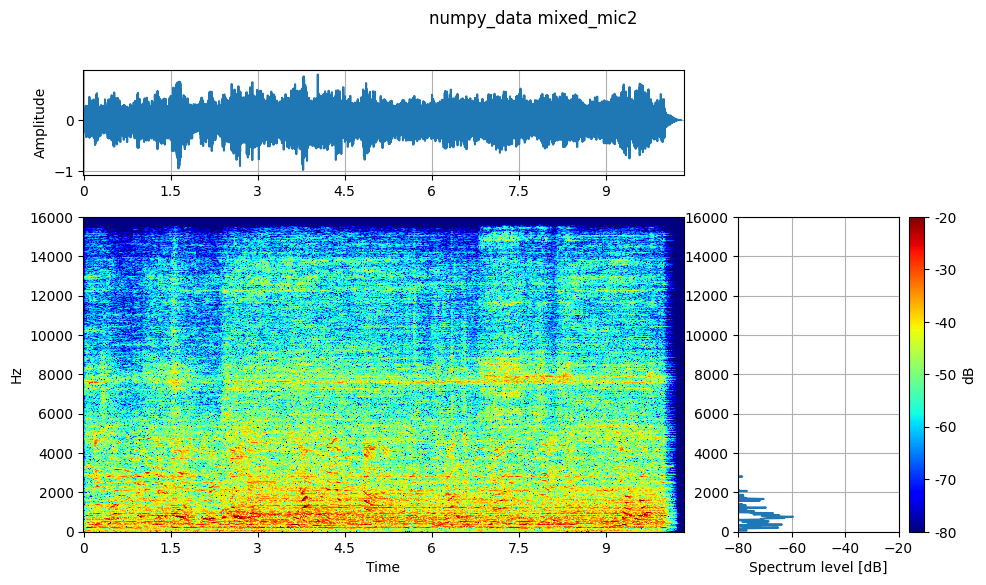

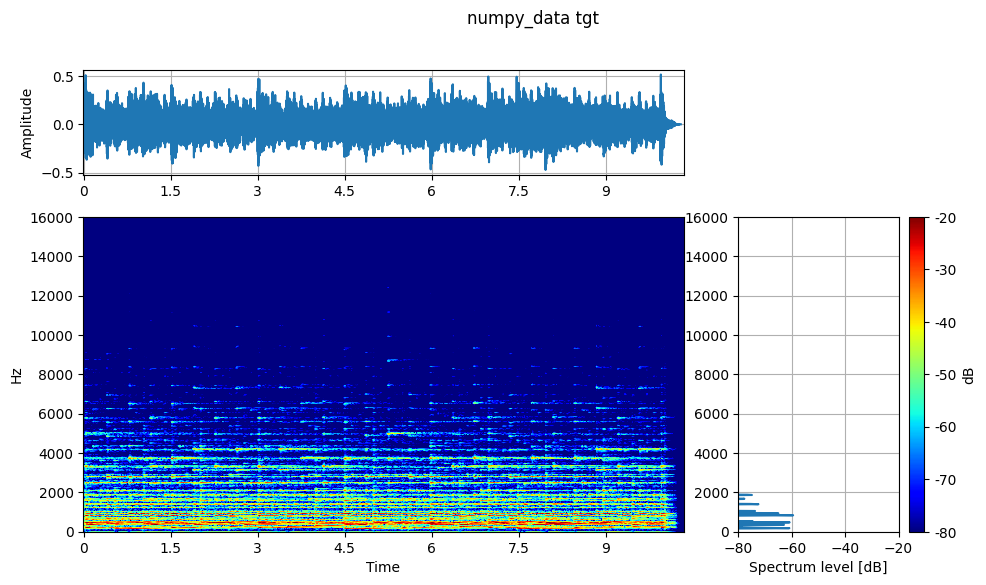

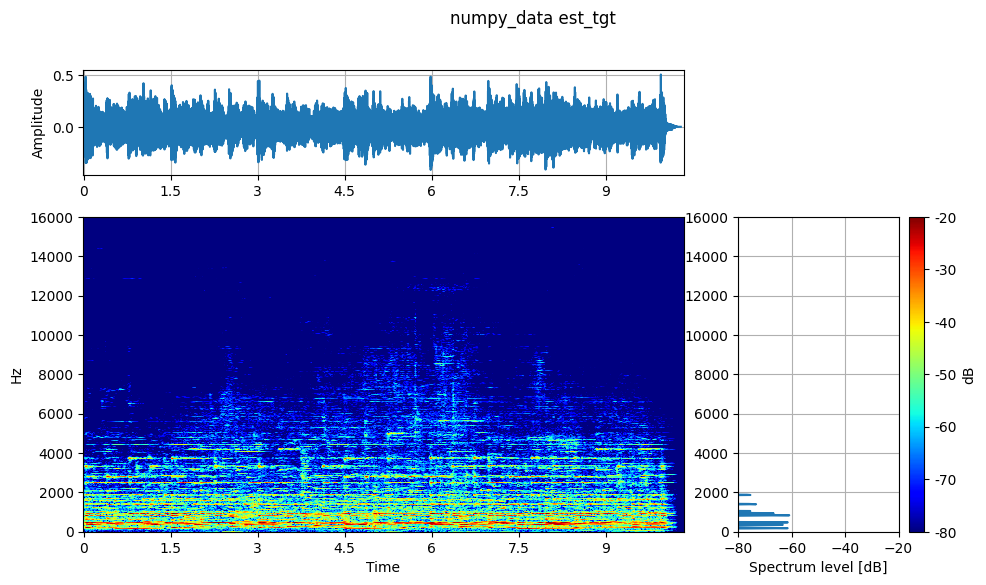

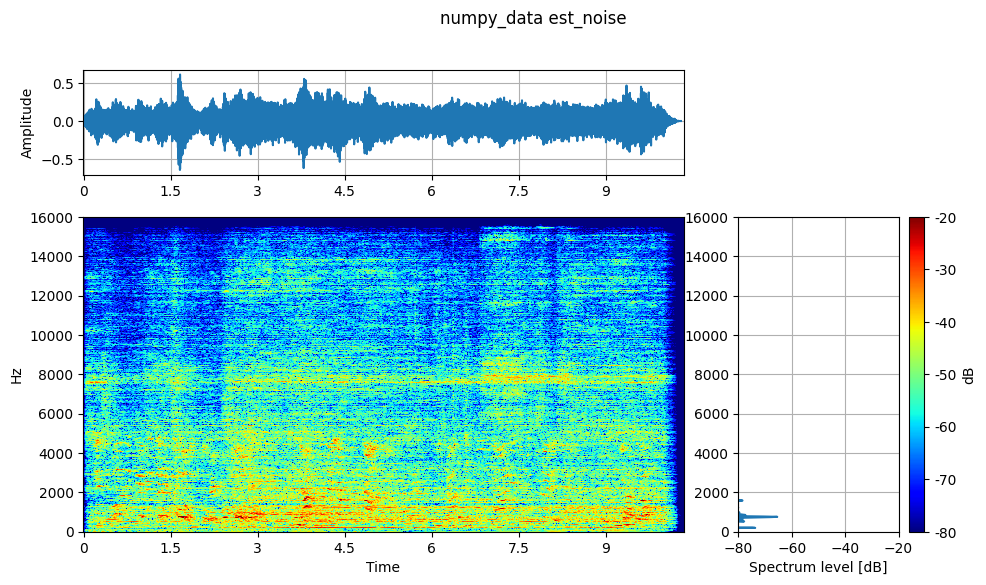

In [8]:
sep_signal_segment.describe(vmax=-20, vmin=-80)
